In [1]:
# импортируем все что нужно

import numpy as np
import pandas as pd
from pathlib import Path
import copy

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import torch.nn.functional as F
import math

from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc

import random

In [2]:
# пути для инпут файлов, в папке faces_aligned_pred_all лежат изображения выровненные с помощью 2_Face_alignment.ipynb
# в aligned_pred_all.csv лежат image_id и identity для этих изображений

data_path = Path("/kaggle/input/data-for-recognition/faces_aligned_pred_all")
csv_path = data_path / "aligned_pred_all.csv"

In [3]:
# проверяем сколько у нас всего выровненных изображений
file_count = len([f for f in data_path.iterdir() if f.is_file()])
file_count

25001

In [4]:
# проверяем что все выглядит ок
df = pd.read_csv(csv_path)
print(df.shape)
df.head()

(25000, 2)


,image_id,identity
0,136627.jpg,3511
1,039611.jpg,7511
2,090411.jpg,6730
3,201044.jpg,7012
4,041575.jpg,5637


Text(0.5, 1.0, 'Distribution of Images per Identity')

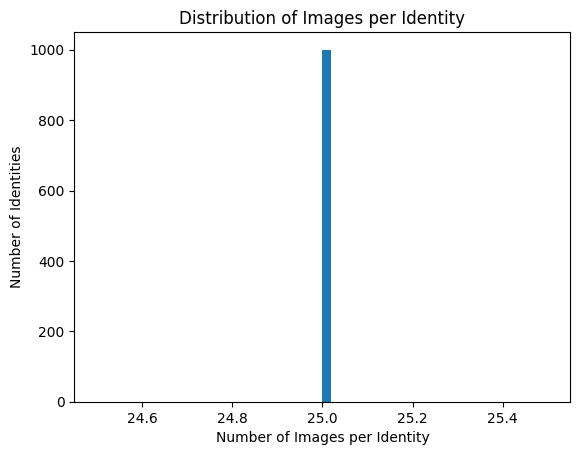

In [5]:
# проверяем что все выглядит ок
identity_counts = df['identity'].value_counts()
plt.hist(identity_counts, bins=50)
plt.xlabel("Number of Images per Identity")
plt.ylabel("Number of Identities")
plt.title("Distribution of Images per Identity")

In [6]:
output_dir_cropped = Path("/kaggle/working/faces_recognition_224")    
output_dir_cropped.mkdir(parents=True, exist_ok=True)

# так как будем использовать реснет, но дополнительно обрежем картинки до 224x224
CROP_SIZE = 224

def center_crop(img, crop_size):
    w, h = img.size
    left = (w - crop_size) // 2
    top = (h - crop_size) // 2
    return img.crop((left, top, left + crop_size, top + crop_size))

for p in tqdm(sorted(data_path.glob("*"))):

    if p.suffix.lower() == ".csv":
        continue
    
    img = Image.open(p).convert("RGB")

    crop = center_crop(img, CROP_SIZE)

    out_path = output_dir_cropped / (p.stem + ".jpg")
    crop.save(out_path, format="JPEG")

100%|██████████| 25001/25001 [02:01<00:00, 206.00it/s]


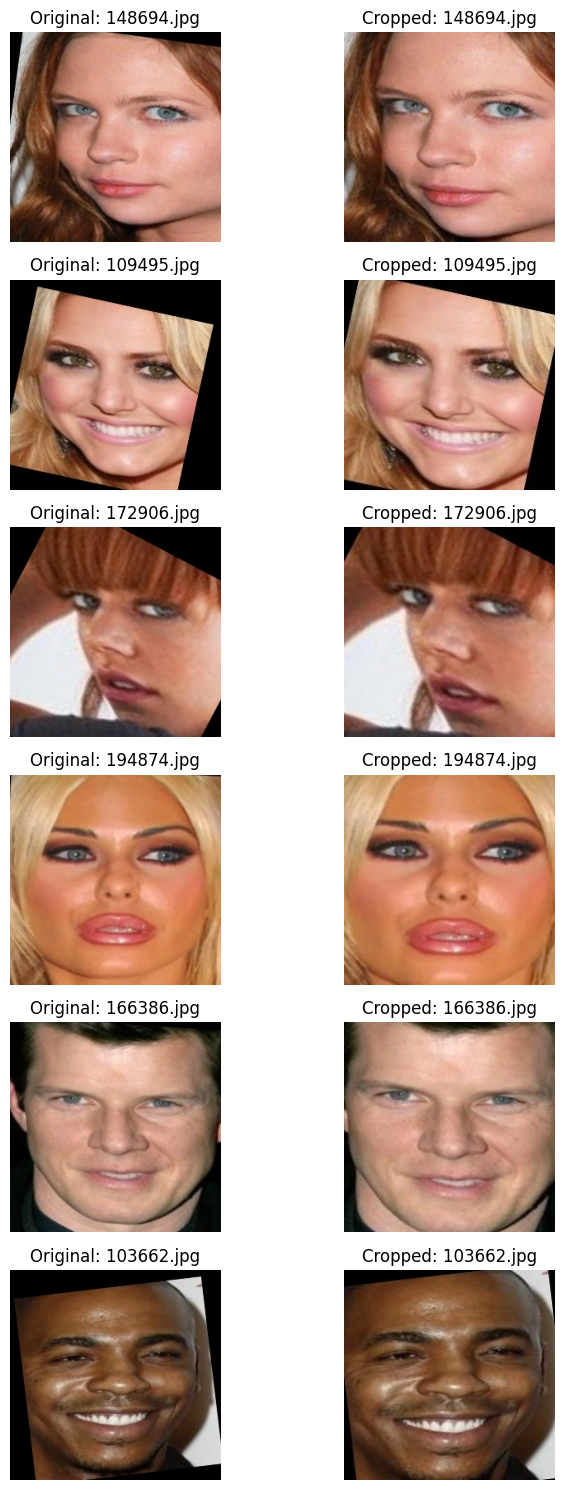

In [7]:
# отрисуем 6 рандомных картинок, чтоб проверить, что все с обрезанием все ок

sample = df.sample(6)

fig, axes = plt.subplots(6, 2, figsize=(8, 15))

for i, row in enumerate(sample.itertuples()):

    axes[i, 0].set_title(f"Original: {row.image_id}")
    img = Image.open(data_path / row.image_id)
    axes[i, 0].imshow(img)
    axes[i, 0].axis("off")

    axes[i, 1].set_title(f"Cropped: {row.image_id}")
    img_cropped = Image.open(output_dir_cropped / row.image_id)
    axes[i, 1].imshow(img_cropped)
    axes[i, 1].axis("off")

plt.tight_layout()

In [8]:
SEED = 21
TRAIN_PER_ID, VAL_PER_ID, TEST_PER_ID = 18, 4, 3 # такая разбивка показалась мне наиболее разумной
PER_ID_TOTAL = TRAIN_PER_ID + VAL_PER_ID + TEST_PER_ID

In [9]:
output_dir_splits = Path("/kaggle/working/splits")    
output_dir_splits.mkdir(parents=True, exist_ok=True)

for split in ["train", "val", "test"]:
    (output_dir_splits / split).mkdir(parents=True, exist_ok=True)

In [10]:
rng = np.random.RandomState(SEED)

rows_out = []

# тут мы проходим по всем identities и для заданной identity выбираем TRAIN_PER_ID картинок в train, VAL_PER_ID в val и тд
for ident, g in tqdm(df.groupby("identity"), total=df["identity"].nunique()):
    g = g.sample(frac=1.0, random_state=SEED).reset_index(drop=True)  
    g = g.iloc[:PER_ID_TOTAL].copy()  

    split_labels = (["train"] * TRAIN_PER_ID) + (["val"] * VAL_PER_ID) + (["test"] * TEST_PER_ID)
    g["split"] = split_labels

    for _, r in g.iterrows():

        src = output_dir_cropped / r["image_id"]
        dst_dir = output_dir_splits / r["split"] / str(r["identity"])
        dst_dir.mkdir(parents=True, exist_ok=True)
        dst = dst_dir / src.name
        shutil.copy2(src, dst)

    rows_out.append(g[["image_id", "identity", "split"]])

df_split = pd.concat(rows_out, axis=0).reset_index(drop=True)

df_split[df_split["split"]=="train"].to_csv(output_dir_splits / "train.csv", index=False)
df_split[df_split["split"]=="val"].to_csv(output_dir_splits / "val.csv", index=False)
df_split[df_split["split"]=="test"].to_csv(output_dir_splits / "test.csv", index=False)

100%|██████████| 1000/1000 [00:07<00:00, 127.10it/s]


In [11]:
DATA_ROOT = Path("/kaggle/working/recog_split")
BATCH_SIZE = 8 # уменьшил размер батча
NUM_WORKERS = 2  

# ImageNet нормализация
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

# тут я еще сверху добавил всяких преобразований, они дали норм буст в accuracy
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [12]:
# для triple loss нам нужно, чтобы датасет возвращал тройки (anchor, positive, negative)
class TripletImageFolder(torch.utils.data.Dataset): 

    def __init__(self, root, transform=None, seed=21):  

        self.base = datasets.ImageFolder(root=root, transform=transform)

        self.transform = transform  
        self.seed = seed             

        # строим словарь, который для каждого класса хранит список индексов изображений этого класса в датасете
        self.class_to_indices = {}

        for idx, (_, y) in enumerate(self.base.samples):
            if y not in self.class_to_indices:
                self.class_to_indices[y] = []
            self.class_to_indices[y].append(idx)

        # cписок всех классов (используется при выборе негативного примера)
        self.all_classes = list(self.class_to_indices.keys())

        # фиксируем сид для воспроизводимости
        self.rng = random.Random(seed)

    def __len__(self):
        return len(self.base)

    def __getitem__(self, index):  

        # выбираем якорь, это просто картинка по запрошенному индексу
        a_img, a_y = self.base[index]

        # находим все картинки того же класса, что и якорь
        same_class_indices = self.class_to_indices[a_y]

        # выбираем другую картинку, он должен быть из того же класса
        pos_index = index
        while pos_index == index:
            pos_index = self.rng.choice(same_class_indices)

        p_img, p_y = self.base[pos_index]

        # выбираем другой класс что achor и positive
        neg_y = a_y
        while neg_y == a_y:
            neg_y = self.rng.choice(self.all_classes)

        # и выбираем картинку из этого другого класса
        neg_index = self.rng.choice(self.class_to_indices[neg_y])
        n_img, n_y = self.base[neg_index]

        return a_img, p_img, n_img, a_y


In [13]:
train_triplet_ds = TripletImageFolder(output_dir_splits / "train", transform=train_tfms, seed=SEED) 
val_triplet_ds   = TripletImageFolder(output_dir_splits / "val",   transform=eval_tfms,  seed=SEED)  
test_triplet_ds  = TripletImageFolder(output_dir_splits / "test",  transform=eval_tfms,  seed=SEED)  

train_triplet_loader = DataLoader(train_triplet_ds, batch_size=BATCH_SIZE, shuffle=True,
                                  num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)  
val_triplet_loader   = DataLoader(val_triplet_ds,   batch_size=BATCH_SIZE, shuffle=False,
                                  num_workers=NUM_WORKERS, pin_memory=True, drop_last=False) 
test_triplet_loader  = DataLoader(test_triplet_ds,  batch_size=BATCH_SIZE, shuffle=False,
                                  num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)  

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# собираем бэккбон и небольшая голова для получения эмбеддингов
class SimpleEmbedder(nn.Module): 

    def __init__(self, backbone, in_features, emb_dim):
        super().__init__()
        self.backbone = backbone  
        self.proj = nn.Sequential(  
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, emb_dim),
        )
        self.bn = nn.BatchNorm1d(emb_dim, affine=False)  

    def forward(self, x):
        z = self.backbone(x)  
        z = self.proj(z)  
        z = self.bn(z)  
        z = F.normalize(z, p=2, dim=1)  
        return z  

# здесь я взял реснет18, так как с реснет50 у меня были проблемы с паматью на каггле
backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1) 
in_features = backbone.fc.in_features  
backbone.fc = nn.Identity()  

model_triplet = SimpleEmbedder(backbone, in_features, 256).to(device) 

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 153MB/s]


In [16]:
# задаем лосс
triplet_margin = 0.2 
criterion_triplet = nn.TripletMarginLoss(margin=triplet_margin, p=2) 

# и метрику, взял самую простую, которая просто считает долю случаев, когда positive ближе к anchor, чем negative
@torch.no_grad()
def triplet_metric(a_emb, p_emb, n_emb):  
    d_ap = torch.norm(a_emb - p_emb, p=2, dim=1)  
    d_an = torch.norm(a_emb - n_emb, p=2, dim=1)  
    return (d_ap < d_an).float().mean().item()  

In [17]:
# тут все стандартно

@torch.no_grad()
def evaluate_triplet(model, loader, criterion, device):  

    model.eval()
    total_loss = 0.0
    total_m = 0.0
    n = 0
    
    for a, p, neg, _ in loader:  
        a = a.to(device)
        p = p.to(device)
        neg = neg.to(device)

        a_emb = model(a)  
        p_emb = model(p)  
        n_emb = model(neg)  

        loss = criterion(a_emb, p_emb, n_emb)  
        m = triplet_metric(a_emb, p_emb, n_emb)  

        bs = a.size(0)
        total_loss += float(loss.item()) * bs
        total_m += float(m) * bs
        n += bs

    return total_loss /n, total_m /n 

In [18]:
# тут тоже
def train_one_epoch_triplet(model, loader, criterion, optimizer, device):  
    model.train()
    total_loss = 0.0
    total_m = 0.0
    n = 0

    for a, p, neg, _ in tqdm(loader, desc="train", leave=False):  
        a = a.to(device)
        p = p.to(device)
        neg = neg.to(device)

        optimizer.zero_grad()

        a_emb = model(a)  
        p_emb = model(p)  
        n_emb = model(neg)  

        loss = criterion(a_emb, p_emb, n_emb)  
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            m = triplet_metric(a_emb, p_emb, n_emb)  

        bs = a.size(0)
        total_loss += float(loss.item()) * bs
        total_m += float(m) * bs
        n += bs

    return total_loss / n, total_m / n

In [19]:
# и тут
EPOCHS = 50  
BEST_PATH_TRIPLET = "/kaggle/working/best_triplet.pth"  

optimizer = optim.AdamW(model_triplet.parameters(), lr=1e-3, weight_decay=1e-4)  
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS) 

best_val_metric = -1.0  
history_triplet = {"train_loss": [], "val_loss": [], "train_metric": [], "val_metric": []}  

for epoch in range(1, EPOCHS + 1):  
    train_loss, train_m = train_one_epoch_triplet(model_triplet, train_triplet_loader, criterion_triplet, optimizer, device)  
    val_loss, val_m = evaluate_triplet(model_triplet, val_triplet_loader, criterion_triplet, device)  
    scheduler.step()

    history_triplet["train_loss"].append(train_loss)  
    history_triplet["val_loss"].append(val_loss)  
    history_triplet["train_metric"].append(train_m)  
    history_triplet["val_metric"].append(val_m)  

    print(f"Epoch={epoch:02d} train_loss={train_loss:.4f} val_loss={val_loss:.4f} train_metric={train_m:.4f} val_metric={val_m:.4f}")  

    if val_m > best_val_metric:
        best_val_metric = val_m  
        torch.save({
            "epoch": epoch,
            "model_state_dict": model_triplet.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_metric": best_val_metric,
        }, BEST_PATH_TRIPLET)  
        print(f"!!! Saved best triplet model, val_m={val_m:.4f}") 


Epoch=01 train_loss=0.2891 val_loss=0.2561 train_metric=0.5627 val_metric=0.5938
!!! Saved best triplet model, val_m=0.5938


Epoch=02 train_loss=0.2524 val_loss=0.2416 train_metric=0.5724 val_metric=0.5925


Epoch=03 train_loss=0.2303 val_loss=0.2067 train_metric=0.5952 val_metric=0.6332
!!! Saved best triplet model, val_m=0.6332


Epoch=04 train_loss=0.2030 val_loss=0.1945 train_metric=0.6256 val_metric=0.6603
!!! Saved best triplet model, val_m=0.6603


Epoch=05 train_loss=0.1833 val_loss=0.1765 train_metric=0.6606 val_metric=0.6960
!!! Saved best triplet model, val_m=0.6960


Epoch=06 train_loss=0.1628 val_loss=0.1641 train_metric=0.6901 val_metric=0.7230
!!! Saved best triplet model, val_m=0.7230


Epoch=07 train_loss=0.1475 val_loss=0.1457 train_metric=0.7219 val_metric=0.7465
!!! Saved best triplet model, val_m=0.7465


Epoch=08 train_loss=0.1223 val_loss=0.1199 train_metric=0.7695 val_metric=0.7900
!!! Saved best triplet model, val_m=0.7900


Epoch=09 train_loss=0.1146 val_loss=0.1164 train_metric=0.7804 val_metric=0.7913
!!! Saved best triplet model, val_m=0.7913


Epoch=10 train_loss=0.1068 val_loss=0.1040 train_metric=0.7959 val_metric=0.8115
!!! Saved best triplet model, val_m=0.8115


Epoch=11 train_loss=0.0987 val_loss=0.0931 train_metric=0.8068 val_metric=0.8250
!!! Saved best triplet model, val_m=0.8250


Epoch=12 train_loss=0.0908 val_loss=0.0945 train_metric=0.8224 val_metric=0.8245


Epoch=13 train_loss=0.0848 val_loss=0.0927 train_metric=0.8325 val_metric=0.8257
!!! Saved best triplet model, val_m=0.8257


Epoch=14 train_loss=0.0817 val_loss=0.0814 train_metric=0.8376 val_metric=0.8445
!!! Saved best triplet model, val_m=0.8445


Epoch=15 train_loss=0.0736 val_loss=0.0856 train_metric=0.8515 val_metric=0.8375


Epoch=16 train_loss=0.0665 val_loss=0.0781 train_metric=0.8672 val_metric=0.8472
!!! Saved best triplet model, val_m=0.8472


Epoch=17 train_loss=0.0616 val_loss=0.0781 train_metric=0.8777 val_metric=0.8452


Epoch=18 train_loss=0.0552 val_loss=0.0771 train_metric=0.8907 val_metric=0.8488
!!! Saved best triplet model, val_m=0.8488


Epoch=19 train_loss=0.0516 val_loss=0.0735 train_metric=0.8963 val_metric=0.8602
!!! Saved best triplet model, val_m=0.8602


Epoch=20 train_loss=0.0496 val_loss=0.0723 train_metric=0.9021 val_metric=0.8602


Epoch=21 train_loss=0.0459 val_loss=0.0670 train_metric=0.9092 val_metric=0.8685
!!! Saved best triplet model, val_m=0.8685


Epoch=22 train_loss=0.0420 val_loss=0.0690 train_metric=0.9171 val_metric=0.8652


Epoch=23 train_loss=0.0428 val_loss=0.0615 train_metric=0.9155 val_metric=0.8790
!!! Saved best triplet model, val_m=0.8790


Epoch=24 train_loss=0.0371 val_loss=0.0649 train_metric=0.9264 val_metric=0.8722


Epoch=25 train_loss=0.0355 val_loss=0.0613 train_metric=0.9291 val_metric=0.8812
!!! Saved best triplet model, val_m=0.8812


Epoch=26 train_loss=0.0347 val_loss=0.0582 train_metric=0.9315 val_metric=0.8862
!!! Saved best triplet model, val_m=0.8862


Epoch=27 train_loss=0.0313 val_loss=0.0584 train_metric=0.9372 val_metric=0.8810


Epoch=28 train_loss=0.0317 val_loss=0.0586 train_metric=0.9367 val_metric=0.8820


Epoch=29 train_loss=0.0319 val_loss=0.0566 train_metric=0.9358 val_metric=0.8860


Epoch=30 train_loss=0.0275 val_loss=0.0573 train_metric=0.9464 val_metric=0.8915
!!! Saved best triplet model, val_m=0.8915


Epoch=31 train_loss=0.0280 val_loss=0.0559 train_metric=0.9453 val_metric=0.8895


Epoch=32 train_loss=0.0250 val_loss=0.0560 train_metric=0.9503 val_metric=0.8932
!!! Saved best triplet model, val_m=0.8932


Epoch=33 train_loss=0.0246 val_loss=0.0540 train_metric=0.9524 val_metric=0.8970
!!! Saved best triplet model, val_m=0.8970


Epoch=34 train_loss=0.0225 val_loss=0.0534 train_metric=0.9569 val_metric=0.8942


Epoch=35 train_loss=0.0228 val_loss=0.0496 train_metric=0.9551 val_metric=0.9042
!!! Saved best triplet model, val_m=0.9042


Epoch=36 train_loss=0.0219 val_loss=0.0520 train_metric=0.9581 val_metric=0.9008


Epoch=37 train_loss=0.0199 val_loss=0.0483 train_metric=0.9611 val_metric=0.9052
!!! Saved best triplet model, val_m=0.9052


Epoch=38 train_loss=0.0193 val_loss=0.0523 train_metric=0.9626 val_metric=0.9038


Epoch=39 train_loss=0.0179 val_loss=0.0475 train_metric=0.9652 val_metric=0.9083
!!! Saved best triplet model, val_m=0.9083


Epoch=40 train_loss=0.0186 val_loss=0.0472 train_metric=0.9642 val_metric=0.9107
!!! Saved best triplet model, val_m=0.9107


Epoch=41 train_loss=0.0170 val_loss=0.0510 train_metric=0.9674 val_metric=0.9022


Epoch=42 train_loss=0.0167 val_loss=0.0496 train_metric=0.9691 val_metric=0.9080


Epoch=43 train_loss=0.0167 val_loss=0.0499 train_metric=0.9685 val_metric=0.9065


Epoch=44 train_loss=0.0156 val_loss=0.0464 train_metric=0.9701 val_metric=0.9145
!!! Saved best triplet model, val_m=0.9145


Epoch=45 train_loss=0.0148 val_loss=0.0470 train_metric=0.9717 val_metric=0.9103


Epoch=46 train_loss=0.0150 val_loss=0.0476 train_metric=0.9719 val_metric=0.9125


Epoch=47 train_loss=0.0160 val_loss=0.0475 train_metric=0.9697 val_metric=0.9140


Epoch=48 train_loss=0.0131 val_loss=0.0465 train_metric=0.9758 val_metric=0.9155
!!! Saved best triplet model, val_m=0.9155


Epoch=49 train_loss=0.0140 val_loss=0.0477 train_metric=0.9726 val_metric=0.9103


Epoch=50 train_loss=0.0150 val_loss=0.0468 train_metric=0.9716 val_metric=0.9147


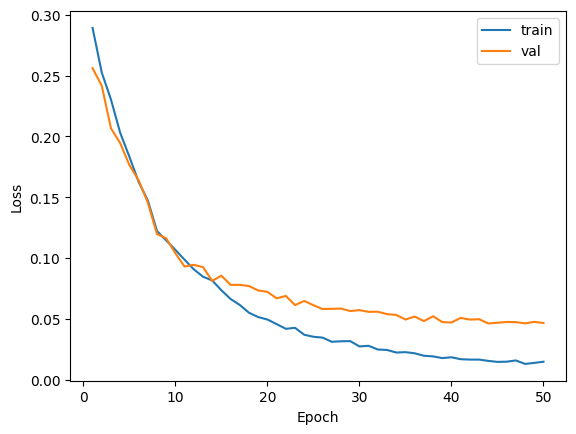

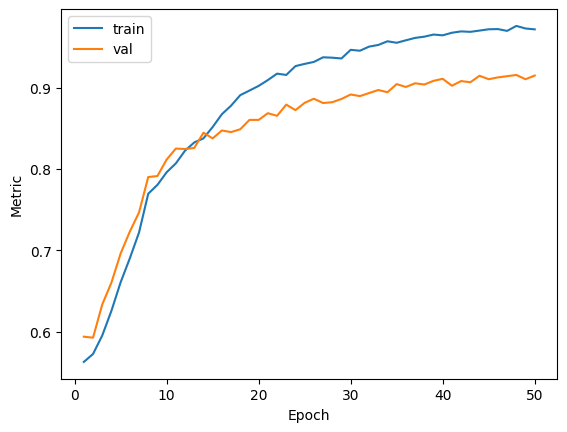

In [20]:
# отрисуем все как положено
epochs = range(1, len(history_triplet["train_loss"]) + 1) 

plt.figure()
plt.plot(list(epochs), history_triplet["train_loss"])
plt.plot(list(epochs), history_triplet["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

plt.figure()
plt.plot(list(epochs), history_triplet["train_metric"])
plt.plot(list(epochs), history_triplet["val_metric"])
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend(["train", "val"])
plt.show()


In [21]:
# и проверим лучшую модель на тесте
ckpt = torch.load(BEST_PATH_TRIPLET, map_location=device)  
best_model_triplet = copy.deepcopy(model_triplet)  
best_model_triplet.load_state_dict(ckpt["model_state_dict"])  
best_model_triplet.to(device).eval()  

test_loss, test_m = evaluate_triplet(best_model_triplet, test_triplet_loader, criterion_triplet, device)  
print("Test metric:", test_m)

Test metric: 0.9086666666666666
